# Gesture Recognition using 2-Stream ST-GCN

This notebook implements a **2-stream Spatial-Temporal Graph Convolutional Network (2S-STGCN)** to classify human gestures using the NTU RGB+D 60 skeleton dataset. It uses both **joint** and **bone** streams to learn spatial relationships and motion patterns between joints over time.

This project supports gesture-based communication between humans and robots in real-world environments like retail, manufacturing, or healthcare where hands-free interaction is more effective.

##Building Spatial Temporal Graphical Convolutional Network - The building blocks of 2s STGCN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):  #Graph Convolution Layer
    def __init__(self, in_channels, out_channels, A, num_joints=25):
        super(GCNLayer, self).__init__()
        self.A = A  # adjacency matrix
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # x: (batch_size, in_channels, T, V)
        N, C, T, V = x.size()

        A = self.A.to(x.device)  # (V, V)
        x = torch.einsum('nctv,vw->nctw', x, A)  # Graph convolution
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        return x


class STGCNBlock(nn.Module):  #STGCN Block - The Backbone
    def __init__(self, in_channels, out_channels, A, stride=1):
        super(STGCNBlock, self).__init__()
        self.gcn = GCNLayer(in_channels, out_channels, A)
        self.tcn = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=(9, 1), stride=(stride, 1), padding=(4, 0)),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)

        if in_channels != out_channels or stride != 1:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1)),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.residual = nn.Identity()

    def forward(self, x):
        res = self.residual(x)
        x = self.gcn(x)
        x = self.tcn(x)
        x = x + res
        x = self.relu(x)
        return x


class STGCN(nn.Module): #Building a network of STGCN network
    def __init__(self, num_class=60, num_joints=25):
        super(STGCN, self).__init__()

        # Define adjacency matrix
        self.A = self.build_adjacency(num_joints)

        # Build ST-GCN backbone
        self.st_gcn_networks = nn.ModuleList([
            STGCNBlock(3, 64, self.A, stride=1),
            STGCNBlock(64, 64, self.A, stride=1),
            STGCNBlock(64, 128, self.A, stride=2),
            STGCNBlock(128, 256, self.A, stride=2)
        ])

        self.pool = nn.AdaptiveAvgPool2d((1,1))  # Global average pooling
        self.fc = nn.Linear(256, num_class)

    def build_adjacency(self, num_joints):
        A = torch.eye(num_joints)  # Start with identity (self loops)
        # Manually add standard NTU connections (optional but better)
        connections = [
            (0,1),(1,20),(20,2),(2,3),(20,8),(8,9),(9,10),
            (1,16),(16,17),(17,18),(1,12),(12,13),(13,14),
            (0,4),(4,5),(5,6),(0,7),(7,21),(21,22),(7,23),(23,24),
            (6,11),(14,19),(11,22),(19,24)
        ]
        for i, j in connections:
            A[i, j] = A[j, i] = 1
        return A

    def forward(self, x):
        # x: (batch_size, 3, T, V)
        for gcn in self.st_gcn_networks:
            x = gcn(x)
        x = self.pool(x)  # (N, C, 1, 1)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out


In [ ]:
model = STGCN(num_class=60)
print(model)

# Input dummy skeleton
x = torch.randn(2, 3, 300, 25)  # (batch_size, channels, frames, joints)
output = model(x)
print(output.shape)  # (2, 120)


STGCN(
  (st_gcn_networks): ModuleList(
    (0): STGCNBlock(
      (gcn): GCNLayer(
        (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (tcn): Sequential(
        (0): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
      (residual): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): STGCNBlock(
      (gcn): GCNLayer(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (tcn): Sequential(
        (0): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 

##Combining the joint stream and bone stream for 2s STGCN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# First reuse the same GCNLayer and STGCNBlock we already built

class TwoStreamGCN(nn.Module):
    def __init__(self, num_class=60, num_joints=25):
        super(TwoStreamGCN, self).__init__()

        self.A = self.build_adjacency(num_joints)

        # Define Joint Stream Backbone
        self.joint_stream = nn.ModuleList([
            STGCNBlock(3, 64, self.A),
            STGCNBlock(64, 64, self.A),
            STGCNBlock(64, 128, self.A, stride=2),
            STGCNBlock(128, 256, self.A, stride=2)
        ])

        # Define Bone Stream Backbone
        self.bone_stream = nn.ModuleList([
            STGCNBlock(3, 64, self.A),
            STGCNBlock(64, 64, self.A),
            STGCNBlock(64, 128, self.A, stride=2),
            STGCNBlock(128, 256, self.A, stride=2)
        ])

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global pooling
        self.fc = nn.Linear(256, num_class)  # Final prediction

    def build_adjacency(self, num_joints):
        A = torch.eye(num_joints)
        connections = [
            (0,1),(1,20),(20,2),(2,3),(20,8),(8,9),(9,10),
            (1,16),(16,17),(17,18),(1,12),(12,13),(13,14),
            (0,4),(4,5),(5,6),(0,7),(7,21),(21,22),(7,23),(23,24),
            (6,11),(14,19),(11,22),(19,24)
        ]
        for i, j in connections:
            A[i, j] = A[j, i] = 1
        return A

    def forward(self, joint, bone):
        # Process Joint Stream
        for layer in self.joint_stream:
            joint = layer(joint)

        # Process Bone Stream
        for layer in self.bone_stream:
            bone = layer(bone)

        # Sum both streams
        x = joint + bone

        # Global pooling and classification
        x = self.pool(x)  # (N, C, 1, 1)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out


##Sample data structure after combining the 2 streams

In [ ]:
model = TwoStreamGCN(num_class=60)

joint_input = torch.randn(4, 3, 300, 25)  # (batch_size, 3, 300, 25)
bone_input = torch.randn(4, 3, 300, 25)

out = model(joint_input, bone_input)
print(out.shape)  # torch.Size([4, 60])


torch.Size([4, 60])


In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/parsed_data" "/content/parsed_data"

^C


In [ ]:
!find "/content/parsed_data" -type f | wc -l

56579


## Initiating the train test split

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

# 1. Set paths
data_folder = "/content/parsed_data"
all_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.npy')])

# 2. Extract labels from file names
labels = []
for file_name in all_files:
    action_id = int(file_name.split('A')[1][:3])
    labels.append(action_id - 1)  # Zero-indexed labels

labels = np.array(labels)

# 3. Stratified split using sklearn
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=18
)

# 4. Define the Dataset
ntu_25_bones = [
    (1, 20), (20, 2), (2, 3), (20, 8), (8, 9), (9, 10),
    (1, 16), (16, 17), (17, 18), (1, 12), (12, 13), (13, 14),
    (0, 1), (0, 4), (4, 5), (5, 6), (0, 7), (7, 21), (21, 22),
    (7, 23), (23, 24), (6, 11), (14, 19), (11, 22), (19, 24)
]

class SkeletonDataset2sSTGCN(Dataset):
    def __init__(self, file_list, data_folder, max_frames=300):
        self.file_list = file_list
        self.data_folder = data_folder
        self.max_frames = max_frames
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        full_path = os.path.join(self.data_folder, file_name)

        data = np.load(full_path, allow_pickle=True).item()
        joints = data['skel_body0']
        T = joints.shape[0]
        V = joints.shape[1]

        if T < self.max_frames:
            pad = np.zeros((self.max_frames - T, V, 3))
            joints = np.concatenate([joints, pad], axis=0)
        else:
            joints = joints[:self.max_frames]

        bones = np.zeros((self.max_frames, V, 3))
        for v1, v2 in ntu_25_bones:
            bones[:, v1, :] = joints[:, v1, :] - joints[:, v2, :]

        joints = joints.transpose(2, 0, 1)  # (3, T, 25)
        bones = bones.transpose(2, 0, 1)    # (3, T, 25)

        action_id = int(file_name.split('A')[1][:3])
        label = action_id - 1

        return {
            'joint': torch.tensor(joints, dtype=torch.float32),
            'bone': torch.tensor(bones, dtype=torch.float32),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 5. Create Train and Test datasets
train_dataset = SkeletonDataset2sSTGCN(train_files, data_folder)
test_dataset = SkeletonDataset2sSTGCN(test_files, data_folder)

# 6. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
sample = test_dataset[61]
print(sample['joint'].shape)  # (3, 300, 25)
print(sample['bone'].shape)   # (3, 300, 25)
print(sample['label'])        # e.g., 4

torch.Size([3, 300, 25])
torch.Size([3, 300, 25])
tensor(32)


##Training the 2s STGCN model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import csv

# 1. Set Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. Initialize Model
model = TwoStreamGCN(num_class=60).to(device)

# 3. Define Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# 4. Early Stopping and Checkpoint Settings
patience = 20
best_test_acc = 0
epochs_no_improve = 0
save_path = "/content/drive/MyDrive/Colab Notebooks/best_model_checkpoint.pth"

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

# 5. Experiment Logging Setup
if not os.path.exists("logs"):
    os.makedirs("logs")

log_file_path = "/content/drive/MyDrive/Colab Notebooks/experiment_log.csv"
log_file = open(log_file_path, mode='w', newline='')
log_writer = csv.writer(log_file)
log_writer.writerow(["Epoch", "Train Loss", "Train Acc", "Test Acc", "Learning Rate"])

# 6. Training Setup
num_epochs = 100
train_losses = []
train_accuracies = []
test_accuracies = []
lr_values = []

# 7. Train Loop
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        joints = batch['joint'].to(device)
        bones = batch['bone'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(joints, bones)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    lr_values.append(current_lr)

    avg_loss = total_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Evaluate on Test Set
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch in test_loader:
            joints = batch['joint'].to(device)
            bones = batch['bone'].to(device)
            labels = batch['label'].to(device)

            outputs = model(joints, bones)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total

    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | LR: {current_lr:.5f}")

    # Write to CSV log
    log_writer.writerow([epoch, avg_loss, train_acc, test_acc, current_lr])

    # Save best checkpoint
    if test_acc > best_test_acc:
        print(f"✅ Saving better model (Test Acc improved from {best_test_acc:.2f}% → {test_acc:.2f}%)")
        best_test_acc = test_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join("checkpoints", save_path))
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"⛔ Early stopping triggered after {patience} epochs without improvement.")
        break

# 8. After Training
log_file.close()
print(f"📄 Experiment log saved to {log_file_path}")

# 9. Load Best Model
model.load_state_dict(torch.load(os.path.join("checkpoints", save_path)))
print("✅ Best model loaded for final evaluation!")

# 10. Final Test Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        joints = batch['joint'].to(device)
        bones = batch['bone'].to(device)
        labels = batch['label'].to(device)

        outputs = model(joints, bones)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_test_acc = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"🎯 Final Test Accuracy after Early Stopping: {final_test_acc:.2f}%")

# 11. Plot Training Curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(15,5))

# Loss Curve
plt.subplot(1,3,1)
plt.plot(epochs_range, train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

# Accuracy Curves
plt.subplot(1,3,2)
plt.plot(epochs_range, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs_range, test_accuracies, label='Test Acc', marker='x')
plt.title('Training vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Learning Rate Curve
plt.subplot(1,3,3)
plt.plot(epochs_range, lr_values, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()

plt.tight_layout()
plt.show()

# 12. Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Epoch [1/100] | Loss: 2.9818 | Train Acc: 19.58% | Test Acc: 23.59% | LR: 0.09973
✅ Saving better model (Test Acc improved from 0.00% → 23.59%)
Epoch [2/100] | Loss: 2.1961 | Train Acc: 36.83% | Test Acc: 30.93% | LR: 0.09891
✅ Saving better model (Test Acc improved from 23.59% → 30.93%)
Epoch [3/100] | Loss: 1.8861 | Train Acc: 44.53% | Test Acc: 46.93% | LR: 0.09755
✅ Saving better model (Test Acc improved from 30.93% → 46.93%)
Epoch [4/100] | Loss: 1.7570 | Train Acc: 48.38% | Test Acc: 46.41% | LR: 0.09568
Epoch [5/100] | Loss: 1.6601 | Train Acc: 50.76% | Test Acc: 29.02% | LR: 0.09330
Epoch [6/100] | Loss: 1.6043 | Train Acc: 52.68% | Test Acc: 20.75% | LR: 0.09045
Epoch [7/100] | Loss: 1.5539 | Train Acc: 53.90% | Test Acc: 39.05% | LR: 0.08716
Epoch [8/100] | Loss: 1.5133 | Train Acc: 55.25% | Test Acc: 40.73% | LR: 0.08346
Epoch [9/100] | Loss: 1.4732 | Train Acc: 56.63% | Test Acc: 51.25% | LR: 0.07939
✅ Saving better model (Test Acc improved from 46.93% → 51.25%)


##**Plotting from log file**

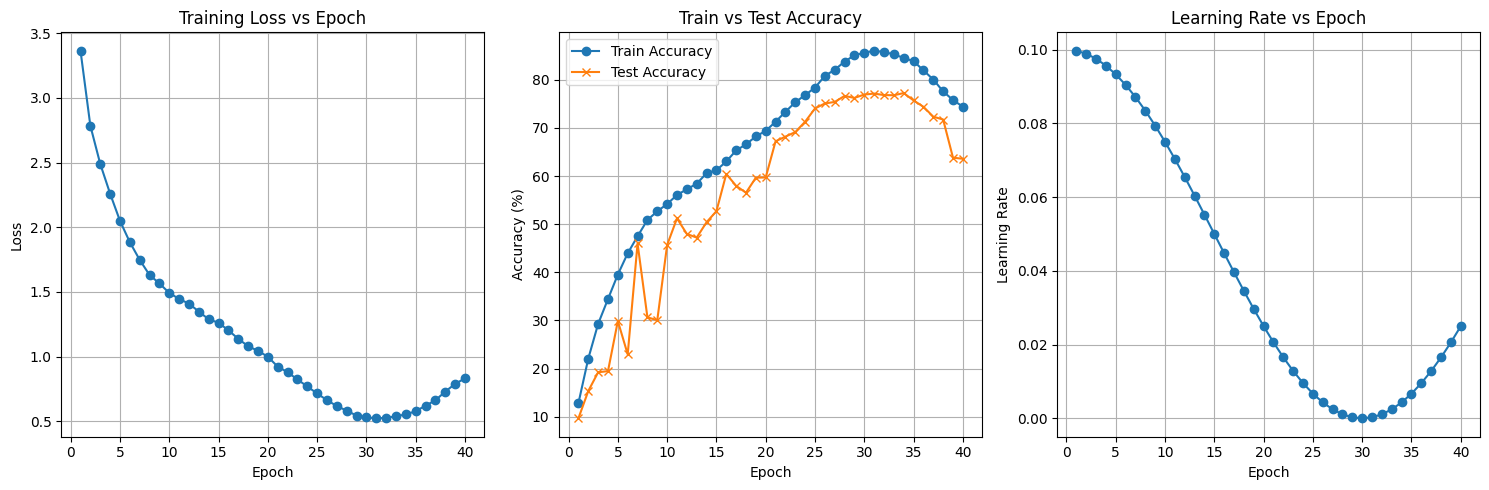

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load Experiment Log CSV
log_path = "/content/drive/MyDrive/Colab Notebooks/experiment_log.csv"  # Path to your CSV file
log_df = pd.read_csv(log_path)

# 2. Plot Everything

epochs = log_df["Epoch"]
train_loss = log_df["Train Loss"]
train_acc = log_df["Train Acc"]
test_acc = log_df["Test Acc"]
learning_rate = log_df["Learning Rate"]

plt.figure(figsize=(15,5))

# Plot Loss
plt.subplot(1,3,1)
plt.plot(epochs, train_loss, marker='o')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

# Plot Accuracy
plt.subplot(1,3,2)
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs, test_acc, label="Test Accuracy", marker='x')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot Learning Rate
plt.subplot(1,3,3)
plt.plot(epochs, learning_rate, marker='o')
plt.title('Learning Rate vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()

plt.tight_layout()
plt.show()


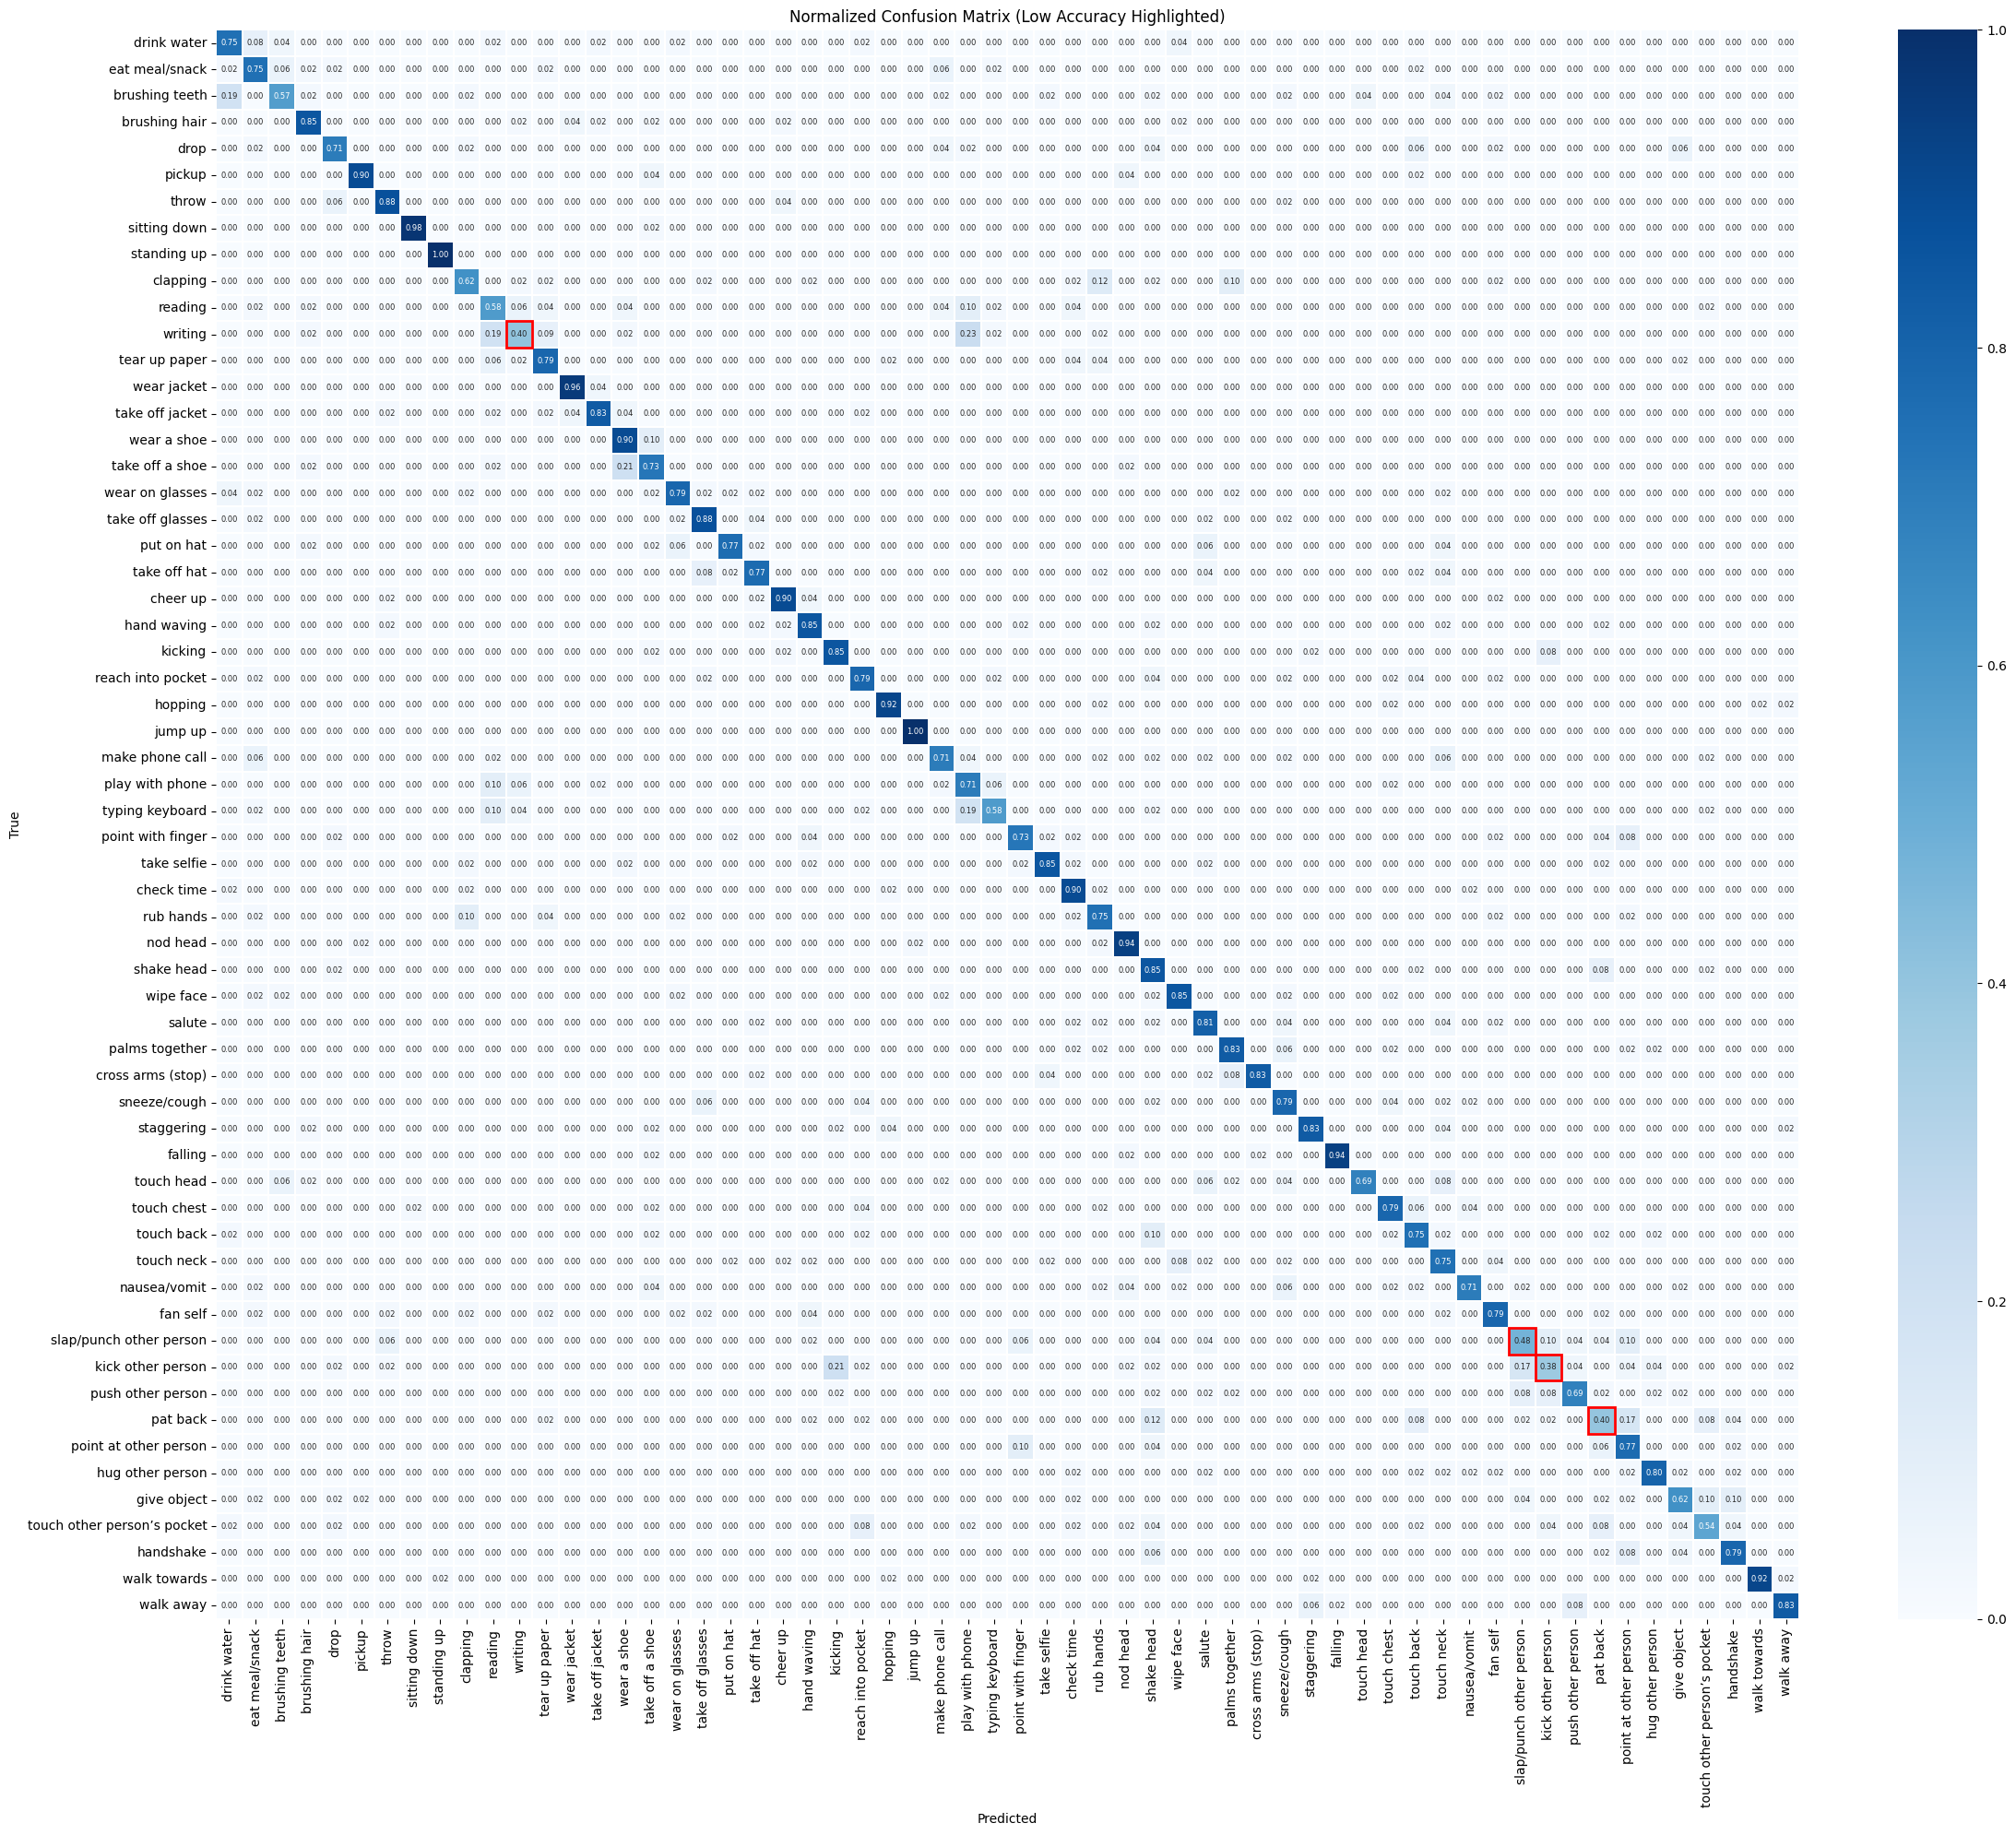


🔝 Top 10 Most Accurate Classes:
standing up                   : 100.00%
jump up                       : 100.00%
sitting down                  : 97.92%
wear jacket                   : 95.83%
nod head                      : 93.75%
falling                       : 93.75%
hopping                       : 91.67%
walk towards                  : 91.67%
pickup                        : 89.58%
wear a shoe                   : 89.58%

🔻 Bottom 10 Least Accurate Classes:
clapping                      : 62.50%
give object                   : 62.50%
reading                       : 58.33%
typing keyboard               : 58.33%
brushing teeth                : 57.45%
touch other person’s pocket   : 54.17%
slap/punch other person       : 47.92%
writing                       : 40.43%
pat back                      : 39.58%
kick other person             : 37.50%

🔁 Top 10 Most Frequent Misclassifications:
writing → play with phone: 11 times
take off a shoe → wear a shoe: 10 times
kick other person → kicking:

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ NTU60 gesture labels (A001 to A060)
gesture_names = [
    "drink water", "eat meal/snack", "brushing teeth", "brushing hair", "drop",
    "pickup", "throw", "sitting down", "standing up", "clapping",
    "reading", "writing", "tear up paper", "wear jacket", "take off jacket",
    "wear a shoe", "take off a shoe", "wear on glasses", "take off glasses", "put on hat",
    "take off hat", "cheer up", "hand waving", "kicking", "reach into pocket",
    "hopping", "jump up", "make phone call", "play with phone", "typing keyboard",
    "point with finger", "take selfie", "check time", "rub hands", "nod head",
    "shake head", "wipe face", "salute", "palms together", "cross arms (stop)",
    "sneeze/cough", "staggering", "falling", "touch head", "touch chest",
    "touch back", "touch neck", "nausea/vomit", "fan self", "slap/punch other person",
    "kick other person", "push other person", "pat back", "point at other person",
    "hug other person", "give object", "touch other person’s pocket", "handshake",
    "walk towards", "walk away"
]

# Ensure length matches
num_classes = len(np.unique(all_labels))
gesture_names = gesture_names[:num_classes]

# ✅ Confusion Matrix (normalized)
cm = confusion_matrix(all_labels, all_preds, normalize='true')
raw_cm = confusion_matrix(all_labels, all_preds)  # for top confusion count

# ✅ Per-class accuracy = diagonal of normalized matrix
class_acc = np.diag(cm) * 100

# ✅ Plot Confusion Matrix with Low-Acc Class Highlighted
plt.figure(figsize=(24, 20))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues',
                 xticklabels=gesture_names, yticklabels=gesture_names,
                 annot_kws={"size": 6}, linewidths=0.3, cbar=True)

# Highlight low-accuracy cells (diagonal values below threshold)
low_acc_threshold = 50  # percent
for i in range(num_classes):
    acc = cm[i, i] * 100
    if acc < low_acc_threshold:
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', linewidth=2))

plt.title("Normalized Confusion Matrix (Low Accuracy Highlighted)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ✅ Show Top and Bottom 10 Class Accuracies
acc_table = list(zip(gesture_names, class_acc))
acc_table.sort(key=lambda x: x[1], reverse=True)

print("\n🔝 Top 10 Most Accurate Classes:")
for name, acc in acc_table[:10]:
    print(f"{name:30s}: {acc:.2f}%")

print("\n🔻 Bottom 10 Least Accurate Classes:")
for name, acc in acc_table[-10:]:
    print(f"{name:30s}: {acc:.2f}%")

# ✅ Top Confusions (raw values)
np.fill_diagonal(raw_cm, 0)  # ignore correct
flat_idx = np.argsort(-raw_cm.ravel())
rows, cols = np.unravel_index(flat_idx, raw_cm.shape)

print("\n🔁 Top 10 Most Frequent Misclassifications:")
count = 0
for true_label, pred_label in zip(rows, cols):
    mis = raw_cm[true_label, pred_label]
    if mis > 0:
        print(f"{gesture_names[true_label]} → {gesture_names[pred_label]}: {mis} times")
        count += 1
        if count == 10: break

# ✅ Precision, Recall, F1-Score per class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(num_classes), zero_division=0)

print("\n📊 Class-wise Precision / Recall / F1:")
for i in range(num_classes):
    print(f"{gesture_names[i]:30s} | Precision: {precision[i]:.2f} | Recall: {recall[i]:.2f} | F1: {f1[i]:.2f}")
